# MNIST Convolutional Neural Network - Final Experiments
The previous experiment gave better results compared to the previous one, with a higher accuracy on the test set. 
However we still had lower results compared to the network we studied, with errors of 0.21% and 0.23%, while ours has around 0.55%. 

From internal tests, increasing the dropout and reducing the number of epochs did not help (as we will show in this notebook using checkpoints we saved), so out last resort is to use image pre-processing to increase the dataset size and make it more generic. We're going to apply some rotation with a window of 30 degrees and both vertical and horizontal shifts with a range of 10% (so about 3 pixels) and see how it behaves compared to our best result. 

## Imports

In [1]:
import os.path
from IPython.display import Image

from util import Util
u = Util()

import numpy as np
# Explicit random seed for reproducibility
np.random.seed(1337)  

Using TensorFlow backend.


In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [3]:
from keras.datasets import mnist

## Definitions

In [4]:
batch_size = 512
nb_classes = 10
nb_epoch = 800
# checkpoint path
checkpoints_filepath_800 = "checkpoints/02_MNIST_relu_weights.best.hdf5"
checkpoints_filepath_56 = "checkpoints/02_MNIST_relu_weights.best_56_epochs.hdf5"
checkpoints_filepath_new = "checkpoints/03_MNIST_weights.best.hdf5"

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters1 = 20
nb_filters2 = 40
# size of pooling area for max pooling
pool_size1 = (2, 2)
pool_size2 = (3, 3)
# convolution kernel size
kernel_size1 = (4, 4)
kernel_size2 = (5, 5)
# dense layer size
dense_layer_size1 = 150
# dropout rate
dropout = 0.15
# activation type
activation = 'relu'

## Data load

In [6]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

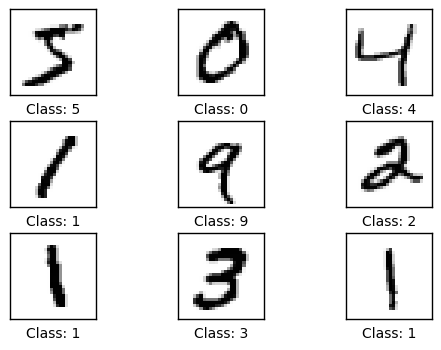

In [7]:
u.plot_images(X_train[0:9], y_train[0:9])

In [8]:
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [10]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## Image preprocessing
As said in the introduction, we're going to apply random transformations: rotation with a window of 30 degrees and both vertical and horizontal shifts with a range of 10% (so about 3 pixels). We avoid flips and rotations that would basically alter the meaning of the symbol.

In [11]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

## Model definition

In [12]:
model_800 = Sequential()
model_56 = Sequential()

model_new = Sequential()

def initialize_network(model, checkpoints_filepath, dropout1=dropout, dropout2=dropout):
    model.add(Convolution2D(nb_filters1, kernel_size1[0], kernel_size1[1],
                            border_mode='valid',
                            input_shape=input_shape, name='covolution_1_' + str(nb_filters1) + '_filters'))
    model.add(Activation(activation, name='activation_1_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size1, name='max_pooling_1_' + str(pool_size1) + '_pool_size'))
    model.add(Convolution2D(nb_filters2, kernel_size2[0], kernel_size2[1]))
    model.add(Activation(activation, name='activation_2_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size2, name='max_pooling_1_' + str(pool_size2) + '_pool_size'))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(dense_layer_size1, name='fully_connected_1_' + str(dense_layer_size1) + '_neurons'))
    model.add(Activation(activation, name='activation_3_' + activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, name='output_' + str(nb_classes) + '_neurons'))
    model.add(Activation('softmax', name='softmax'))

    # loading weights from checkpoints 
    if os.path.exists(checkpoints_filepath):
        model.load_weights(checkpoints_filepath)
    else:
        print ("Warning: file not found. This notebook requires the file containing the weights")

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy', 'precision', 'recall', 'mean_absolute_error'])
    
initialize_network(model_800, checkpoints_filepath_800)
initialize_network(model_56, checkpoints_filepath_56)

initialize_network(model_new, checkpoints_filepath_new)

## Training and evaluation

In [13]:
# evaluation
print('evaluating 800 epochs model')
score = model_800.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print('Test error:', (1-score[2])*100, '%')
print('Test MAE:', score[4])

print('evaluating 56 epochs model')
score = model_56.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print('Test error:', (1-score[2])*100, '%')
print('Test MAE:', score[4])

evaluating 800 epochs model
 9984/10000 [============================>.] - ETA: 0sTest score: 0.0357797718857
Test accuracy: 0.9944
Test error: 0.550322589874 %
Test MAE: 0.00137426248779
evaluating 56 epochs model
 9984/10000 [============================>.] - ETA: 0sTest score: 0.0291260985197
Test accuracy: 0.9927
Test error: 0.690967769623 %
Test MAE: 0.00215386607419


In [14]:
# checkpoint
checkpoint_new = ModelCheckpoint(checkpoints_filepath_new, monitor='val_precision', verbose=1, save_best_only=True, mode='max')
callbacks_list_new = [checkpoint_new]

if os.path.exists('distorted_data/0.png'):
    flow = datagen.flow_from_directory('distorted_data',
                                       target_size=(img_rows, img_cols),
                                       batch_size=batch_size,
                                       class_mode='binary',
                                       seed=1337)
else:
    flow = datagen.flow(X_train, Y_train, 
                        batch_size=batch_size, 
                        seed=1337,
                        save_to_dir='distorted_data', save_format='png')
    

# fits the model on batches with real-time data augmentation:
history_new = model_new.fit_generator(flow,
                    samples_per_epoch=len(X_train), nb_epoch=nb_epoch, verbose=0, 
                    validation_data=(X_test, Y_test), callbacks=callbacks_list_new)

# ensuring best val_precision reached during training
model_new.load_weights(checkpoints_filepath_new)

Epoch 00000: val_precision improved from -inf to 0.92299, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00001: val_precision improved from 0.92299 to 0.95309, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00002: val_precision improved from 0.95309 to 0.95347, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00003: val_precision improved from 0.95347 to 0.97033, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00004: val_precision improved from 0.97033 to 0.97067, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00005: val_precision improved from 0.97067 to 0.97790, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00006: val_precision improved from 0.97790 to 0.97957, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00007: val_precision did not improve
Epoch 00008: val_precision improved from 0.97957 to 0.98052, saving model to checkpoints/03_MNIST_weights.best.hdf5
Epoch 00009: val_precision impro

In [15]:
# evaluation
print('evaluating new model')
score = model_new.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print('Test error:', (1-score[2])*100, '%')
print('Test MAE:', score[4])

evaluating new model
 9952/10000 [============================>.] - ETA: 0sTest score: 0.0200778604679
Test accuracy: 0.9942
Test error: 0.510645179749 %
Test MAE: 0.00223911666629


dict_keys(['loss', 'mean_absolute_error', 'val_recall', 'val_mean_absolute_error', 'recall', 'val_loss', 'val_acc', 'val_precision', 'precision', 'acc'])


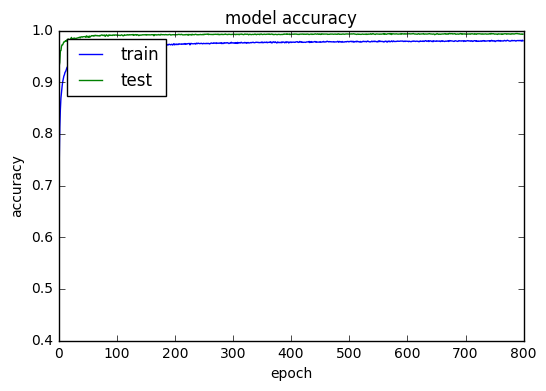

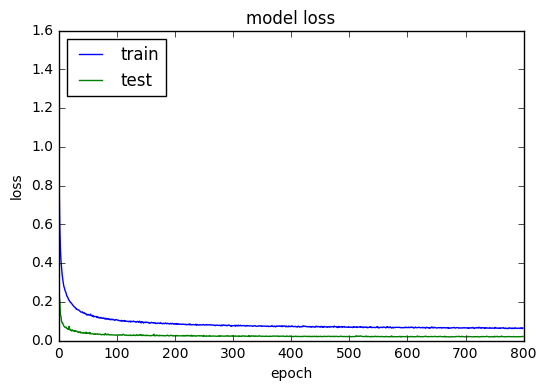

In [16]:
u.plot_history(history_new)
u.plot_history(history_new, 'precision')
u.plot_history(history_new, metric='loss', loc='upper left')

## Inspecting the result

In [17]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes_800 = model_800.predict_classes(X_test)
predicted_classes_56 = model_56.predict_classes(X_test)
predicted_classes_new = model_new.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices_800 = np.nonzero(predicted_classes_800 == y_test)[0]
incorrect_indices_800 = np.nonzero(predicted_classes_800 != y_test)[0]

correct_indices_56 = np.nonzero(predicted_classes_56 == y_test)[0]
incorrect_indices_56 = np.nonzero(predicted_classes_56 != y_test)[0]

correct_indices_new = np.nonzero(predicted_classes_new == y_test)[0]
incorrect_indices_new = np.nonzero(predicted_classes_new != y_test)[0]

10000/10000 [==============================] - 0s     


### Examples of correct predictions (800)

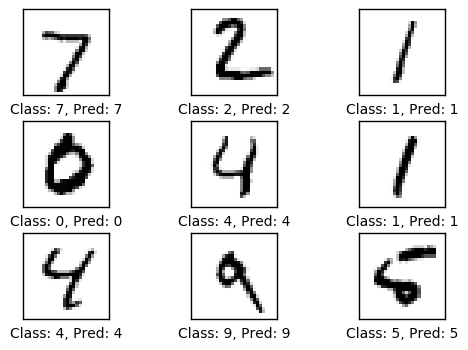

In [18]:
u.plot_images(X_test[correct_indices_800[:9]], y_test[correct_indices_800[:9]], 
              predicted_classes_800[correct_indices_800[:9]])

### Examples of incorrect predictions (800)

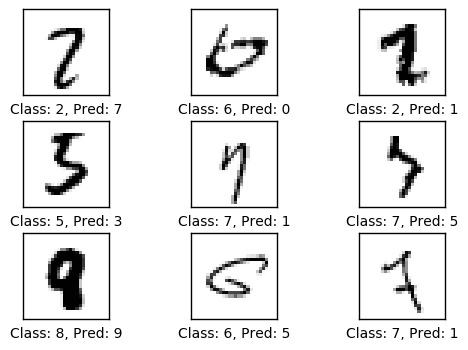

In [19]:
u.plot_images(X_test[incorrect_indices_800[:9]], y_test[incorrect_indices_800[:9]], 
              predicted_classes_800[incorrect_indices_800[:9]])

### Examples of correct predictions (56)

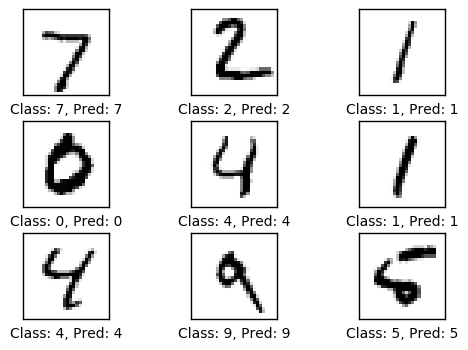

In [20]:
u.plot_images(X_test[correct_indices_56[:9]], y_test[correct_indices_56[:9]], 
              predicted_classes_56[correct_indices_56[:9]])

### Examples of incorrect predictions (56)

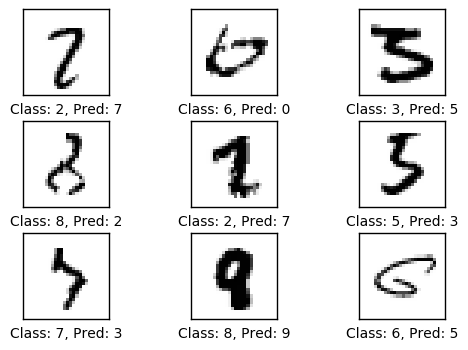

In [21]:
u.plot_images(X_test[incorrect_indices_56[:9]], y_test[incorrect_indices_56[:9]], 
              predicted_classes_56[incorrect_indices_56[:9]])

### Examples of correct predictions (new)

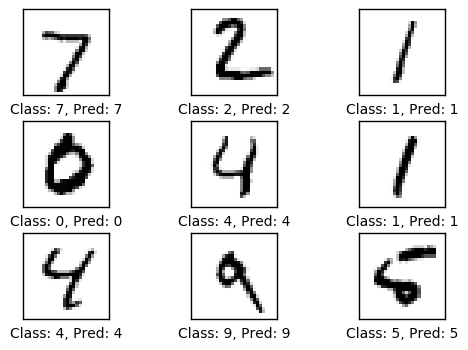

In [22]:
u.plot_images(X_test[correct_indices_new[:9]], y_test[correct_indices_new[:9]], 
              predicted_classes_new[correct_indices_new[:9]])

### Examples of incorrect predictions (new)

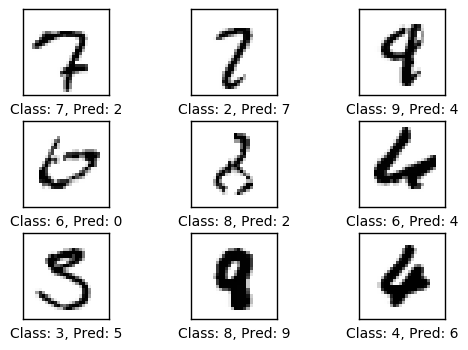

In [23]:
u.plot_images(X_test[incorrect_indices_new[:9]], y_test[incorrect_indices_new[:9]], 
              predicted_classes_new[incorrect_indices_new[:9]])

### Confusion matrix (800)

[[ 975    1    0    0    0    0    1    2    1    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   1    1 1024    2    0    0    0    4    0    0]
 [   0    0    0 1009    0    0    0    1    0    0]
 [   0    0    0    0  981    0    0    0    0    1]
 [   1    0    0    5    0  884    1    1    0    0]
 [   3    2    0    0    1    1  949    0    2    0]
 [   1    4    2    0    0    1    0 1019    1    0]
 [   0    0    0    0    1    0    0    1  971    1]
 [   1    0    0    0    7    1    0    2    1  997]]


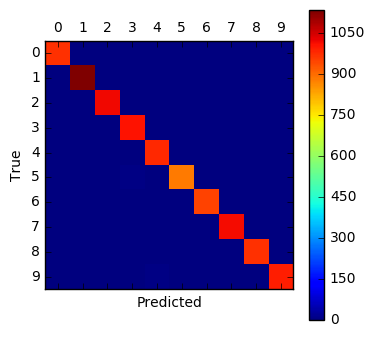

In [24]:
u.plot_confusion_matrix(y_test, nb_classes, predicted_classes_800)

### Confusion matrix (56)

[[ 974    1    1    0    0    0    1    2    1    0]
 [   0 1133    1    1    0    0    0    0    0    0]
 [   1    0 1024    2    0    0    0    5    0    0]
 [   0    0    1 1006    0    3    0    0    0    0]
 [   0    0    0    0  979    0    0    0    1    2]
 [   1    0    0    6    0  881    1    1    2    0]
 [   2    1    0    0    1    3  950    0    1    0]
 [   0    4    5    2    0    0    0 1017    0    0]
 [   1    0    2    1    0    0    0    1  968    1]
 [   1    0    0    0    5    1    0    3    4  995]]


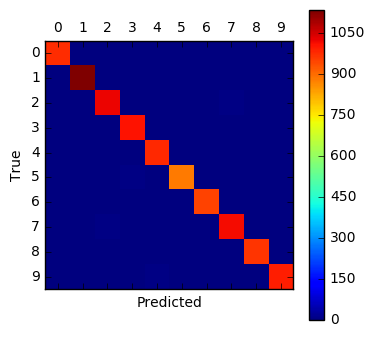

In [25]:
u.plot_confusion_matrix(y_test, nb_classes, predicted_classes_56)

### Confusion matrix (56)

[[ 976    0    0    1    0    0    3    0    0    0]
 [   0 1132    1    0    0    0    1    1    0    0]
 [   1    0 1026    2    0    0    0    3    0    0]
 [   0    1    0 1008    0    1    0    0    0    0]
 [   0    0    0    0  978    0    1    0    0    3]
 [   1    0    0    3    0  884    4    0    0    0]
 [   3    1    1    0    1    0  952    0    0    0]
 [   0    3    7    0    0    0    0 1016    0    2]
 [   0    1    1    0    0    1    0    0  970    1]
 [   1    0    1    0    4    2    0    1    0 1000]]


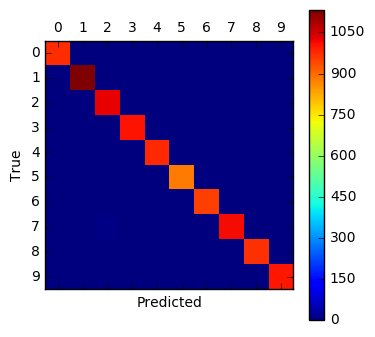

In [26]:
u.plot_confusion_matrix(y_test, nb_classes, predicted_classes_new)

## Results
The time required to perform epoch with image preprocessing was significantly higher, with about 20 seconds for each epoch on our average GPU that was previously able to compute one epoch in 6 seconds for the same network. However the error (calculated as 1-precision) increased from 0.55% to 0.50% after the same number of epochs. It is still unclear if we can use the same preprocessing for the datasets of In Codice Ratio, because characters to classify should be regular as the ones of the training dataset.